In [1]:
%matplotlib inline

In [2]:
# ML and numerical libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# DANN paper implementation helpers
from flip_gradient import flip_gradient
from utils import *

# Text processing
from sklearn.feature_extraction.text import CountVectorizer

# Data visualization
from sklearn.manifold import TSNE

In [3]:
0.39440203# Mandatory for CUDA, NVIDIA, Linux Mint compatibility with middle-level TF code
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
# Read glove embeddings
vocab, w2v = read_data("datasets/embeddings/glove.6B.50d.txt")

Total Words in DataSet: 400000


In [5]:


# Read and preprocess datasets
hurricane_harvey = pd.read_csv(
        'datasets/crisis-mmd/annotations/hurricane_harvey_final_data.tsv', sep='\t', header=0)
hurricane_irma = pd.read_csv(
        'datasets/crisis-mmd/annotations/hurricane_irma_final_data.tsv', sep='\t', header=0)
hurricane_maria = pd.read_csv(
        'datasets/crisis-mmd/annotations/hurricane_maria_final_data.tsv', sep='\t', header=0)
source_df = pd.concat([hurricane_harvey, hurricane_irma, hurricane_maria])
source_df = source_df[source_df.text_human.notnull()]
source_df = pd.concat([source_df, pd.get_dummies(source_df['text_human'])], axis=1).drop(['text_human'], axis=1)
source_df = source_df[source_df['text_info'] == 'informative']

target_df = pd.read_csv(
        'datasets/crisis-mmd/annotations/california_wildfires_final_data.tsv', sep='\t', header=0)
target_df = target_df[target_df.text_human.notnull()]
target_df = pd.concat([target_df, pd.get_dummies(target_df['text_human'])], axis=1).drop(['text_human'], axis=1)
target_df = target_df[target_df['text_info'] == 'informative']

source_examples = preprocess_text(source_df['tweet_text'])
source_labels = source_df[['affected_individuals', 'infrastructure_and_utility_damage',
                           'injured_or_dead_people', 'missing_or_found_people',
                           'not_relevant_or_cant_judge', 'other_relevant_information',
                           'rescue_volunteering_or_donation_effort', 'vehicle_damage']]

target_examples = preprocess_text(target_df['tweet_text'])
target_labels = target_df[['affected_individuals', 'infrastructure_and_utility_damage',
                           'injured_or_dead_people', 'missing_or_found_people',
                           'not_relevant_or_cant_judge', 'other_relevant_information',
                           'rescue_volunteering_or_donation_effort', 'vehicle_damage']]

In [15]:
tokenized_source_examples = [example.split() for example in source_examples]
tokenized_target_examples = [example.split() for example in target_examples]
max_pad = 12
padded_source_examples = [(sentence + ['<PAD>'] * (max_pad - len(sentence)))[:max_pad] for sentence in tokenized_source_examples]
padded_target_examples = [(sentence + ['<PAD>'] * (max_pad - len(sentence)))[:max_pad] for sentence in tokenized_target_examples]

w2v['<PAD>'] = np.full((50), -1)

padded_source_examples = np.array([[w2v.get(word, np.full((50), -2)) for word in example] for example in padded_source_examples])
padded_target_examples = np.array([[w2v.get(word, np.full((50), 2)) for word in example] for example in padded_target_examples])

In [16]:
print(padded_source_examples.shape)
print(padded_target_examples.shape)

(9742, 12, 50)
(1245, 12, 50)


In [18]:
# Change shape to convolutional matrix
X = padded_source_examples.reshape((-1, max_pad, 10, 5))
X_target = padded_target_examples.reshape((-1, max_pad, 10, 5))

# Split training and testing data
X_source_train, X_source_test, y_source_train, y_source_test = \
    train_test_split(X, source_labels, test_size=0.3, random_state=42)
X_target_train, X_target_test, y_target_train, y_target_test = \
    train_test_split(X_target, target_labels, test_size=0.3, random_state=42)

In [19]:
# Create a mixed dataset for TSNE visualization
num_test = 200
combined_test_imgs = np.vstack([X_source_test[:num_test], X_target_test[:num_test]])
combined_test_labels = np.vstack([y_source_test[:num_test], y_target_test[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
        np.tile([0., 1.], [num_test, 1])])

In [23]:
batch_size = 64

class DANN_Model(object):
    """Domain adaptation model."""
    def __init__(self):
        self._build_model()

    def _build_model(self):
        self.X = tf.placeholder(tf.uint8, [None, max_pad, 10, 5])
        self.y = tf.placeholder(tf.float32, [None, 8])
        self.domain = tf.placeholder(tf.float32, [None, 2])
        self.l = tf.placeholder(tf.float32, [])
        self.train = tf.placeholder(tf.bool, [])
        
        # CNN model for feature extraction
        with tf.variable_scope('feature_extractor'):

            W_conv0 = weight_variable([5, 5, 5, 32])
            b_conv0 = bias_variable([32])
            h_conv0 = tf.nn.relu(conv2d(tf.cast(self.X, tf.float32), W_conv0) + b_conv0)
            h_pool0 = max_pool_2x2(h_conv0)
            
            W_conv1 = weight_variable([5, 5, 32, 64])
            b_conv1 = bias_variable([64])
            h_conv1 = tf.nn.relu(conv2d(h_pool0, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            
            # The domain-invariant feature
            self.feature = tf.reshape(h_pool1, [-1, 3*3*64])

        # MLP for class prediction
        with tf.variable_scope('label_predictor'):
            
            # Switches to route target examples (second half of batch) differently
            # depending on train or test mode.
            all_features = lambda: self.feature
            source_features = lambda: tf.slice(self.feature, [0, 0], [batch_size // 2, -1])
            classify_feats = tf.cond(self.train, source_features, all_features)
            
            all_labels = lambda: self.y
            source_labels = lambda: tf.slice(self.y, [0, 0], [batch_size // 2, -1])
            self.classify_labels = tf.cond(self.train, source_labels, all_labels)
            
            W_fc0 = weight_variable([3 * 3 * 64, 100])
            b_fc0 = bias_variable([100])
            h_fc0 = tf.nn.relu(tf.matmul(classify_feats, W_fc0) + b_fc0)

            W_fc1 = weight_variable([100, 100])
            b_fc1 = bias_variable([100])
            h_fc1 = tf.nn.relu(tf.matmul(h_fc0, W_fc1) + b_fc1)

            W_fc2 = weight_variable([100, 8])
            b_fc2 = bias_variable([8])
            logits = tf.matmul(h_fc1, W_fc2) + b_fc2
            
            self.pred = tf.nn.softmax(logits)
            self.pred_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=self.classify_labels)

        # Small MLP for domain prediction with adversarial loss
        with tf.variable_scope('domain_predictor'):
            
            # Flip the gradient when backpropagating through this operation
            feat = flip_gradient(self.feature, self.l)
            
            d_W_fc0 = weight_variable([3 * 3 * 64, 100])
            d_b_fc0 = bias_variable([100])
            d_h_fc0 = tf.nn.relu(tf.matmul(feat, d_W_fc0) + d_b_fc0)
            
            d_W_fc1 = weight_variable([100, 2])
            d_b_fc1 = bias_variable([2])
            d_logits = tf.matmul(d_h_fc0, d_W_fc1) + d_b_fc1
            
            self.domain_pred = tf.nn.softmax(d_logits)
            self.domain_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_logits, labels=self.domain)


In [24]:
# Build the model graph
graph = tf.compat.v1.get_default_graph()
with graph.as_default():
    model = DANN_Model()
    
    # Training
    learning_rate = tf.placeholder(tf.float32, [])
    
    pred_loss = tf.reduce_mean(model.pred_loss)
    domain_loss = tf.reduce_mean(model.domain_loss)
    total_loss = pred_loss + domain_loss

    regular_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(pred_loss)
    dann_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(total_loss)
    
    # Evaluation
    correct_label_pred = tf.equal(tf.argmax(model.classify_labels, 1), tf.argmax(model.pred, 1))
    label_acc = tf.reduce_mean(tf.cast(correct_label_pred, tf.float32))
    correct_domain_pred = tf.equal(tf.argmax(model.domain, 1), tf.argmax(model.domain_pred, 1))
    domain_acc = tf.reduce_mean(tf.cast(correct_domain_pred, tf.float32))


In [25]:
def train_and_evaluate(training_mode, graph, model, num_steps=10000, verbose=True):
    """Helper to run the model with different training modes."""

#     with session as sess:
    tf.global_variables_initializer().run()

    # Batch generators
    gen_source_batch = batch_generator(
        [X_source_train, y_source_train], batch_size // 2)
    gen_target_batch = batch_generator(
        [X_target_train, y_target_train], batch_size // 2)
    gen_source_only_batch = batch_generator(
        [X_source_train, y_source_train], batch_size)
    gen_target_only_batch = batch_generator(
        [X_target_train, y_target_train], batch_size)

    domain_labels = np.vstack([np.tile([1., 0.], [batch_size // 2, 1]),
                               np.tile([0., 1.], [batch_size // 2, 1])])

    # Training loop
    for i in range(num_steps):
        if i % 500 == 0:
            print('step {0} out of {1}'.format(i, num_steps))
        # Adaptation param and learning rate schedule as described in the paper
        p = float(i) / num_steps
        l = 2. / (1. + np.exp(-10. * p)) - 1
        # 0.1 -> 0.001
        lr = 0.001 / (1. + 10 * p)**0.75

        # Training step
        if training_mode == 'dann':

            X0, y0 = next(gen_source_batch)
            X1, y1 = next(gen_target_batch)
            X = np.vstack([X0, X1])
            y = np.vstack([y0, y1])

            _, batch_loss, dloss, ploss, d_acc, p_acc = sess.run(
                [dann_train_op, total_loss, domain_loss, pred_loss, domain_acc, label_acc],
                feed_dict={model.X: X, model.y: y, model.domain: domain_labels,
                           model.train: True, model.l: l, learning_rate: lr})

            if verbose and i % 100 == 0:
                print('loss: {}  d_acc: {}  p_acc: {}  p: {}  l: {}  lr: {}'.format(
                        batch_loss, d_acc, p_acc, p, l, lr))

        elif training_mode == 'source':
            X, y = next(gen_source_only_batch)
            _, batch_loss = sess.run([regular_train_op, pred_loss],
                                 feed_dict={model.X: X, model.y: y, model.train: False,
                                            model.l: l, learning_rate: lr})

        elif training_mode == 'target':
            X, y = next(gen_target_only_batch)
            _, batch_loss = sess.run([regular_train_op, pred_loss],
                                 feed_dict={model.X: X, model.y: y, model.train: False,
                                            model.l: l, learning_rate: lr})

    # Compute final evaluation on test data
    source_acc = sess.run(label_acc,
                        feed_dict={model.X: X_source_test, model.y: y_source_test,
                                   model.train: False})

    target_acc = sess.run(label_acc,
                        feed_dict={model.X: X_target_test, model.y: y_target_test,
                                   model.train: False})

    test_domain_acc = sess.run(domain_acc,
                        feed_dict={model.X: combined_test_imgs,
                                   model.domain: combined_test_domain, model.l: 1.0})

    test_emb = sess.run(model.feature, feed_dict={model.X: combined_test_imgs})
    return source_acc, target_acc, test_domain_acc, test_emb


print('\nSource only training')
source_acc, target_acc, _, source_only_emb = train_and_evaluate('source', graph, model)
print('Source accuracy:', source_acc)
print('Target accuracy:', target_acc)

print('\nDomain adaptation training')
source_acc, target_acc, d_acc, dann_emb = train_and_evaluate('dann', graph, model)
print('Source accuracy:', source_acc)
print('Target accuracy:', target_acc)
print('Domain accuracy:', d_acc)


Source only training
step 0 out of 10000
step 500 out of 10000
step 1000 out of 10000
step 1500 out of 10000
step 2000 out of 10000
step 2500 out of 10000
step 3000 out of 10000
step 3500 out of 10000
step 4000 out of 10000
step 4500 out of 10000
step 5000 out of 10000
step 5500 out of 10000
step 6000 out of 10000
step 6500 out of 10000
step 7000 out of 10000
step 7500 out of 10000
step 8000 out of 10000
step 8500 out of 10000
step 9000 out of 10000
step 9500 out of 10000
Source accuracy: 0.5135135
Target accuracy: 0.43048128

Domain adaptation training
step 0 out of 10000
loss: 132.07794189453125  d_acc: 0.5625  p_acc: 0.21875  p: 0.0  l: 0.0  lr: 0.001
loss: 3.065006732940674  d_acc: 0.59375  p_acc: 0.375  p: 0.01  l: 0.049958374957880025  lr: 0.0009310124446222229
loss: 2.1351020336151123  d_acc: 0.546875  p_acc: 0.40625  p: 0.02  l: 0.0996679946249559  lr: 0.0008721959494934214
loss: 1.7677329778671265  d_acc: 0.671875  p_acc: 0.3125  p: 0.03  l: 0.14888503362331806  lr: 0.0008213

loss: 1.8917174339294434  d_acc: 0.5  p_acc: 0.5625  p: 0.66  l: 0.9972829600991422  lr: 0.0002184689924568984
loss: 2.134559154510498  d_acc: 0.5  p_acc: 0.46875  p: 0.67  l: 0.9975412027574453  lr: 0.00021633757443878076
loss: 1.9163541793823242  d_acc: 0.5  p_acc: 0.59375  p: 0.68  l: 0.9977749279342796  lr: 0.00021425405391243442
loss: 2.14731502532959  d_acc: 0.5  p_acc: 0.4375  p: 0.69  l: 0.9979864583598288  lr: 0.00021221676089642016
step 7000 out of 10000
loss: 1.9965113401412964  d_acc: 0.5  p_acc: 0.53125  p: 0.7  l: 0.9981778976111988  lr: 0.00021022410381342865
loss: 1.6865699291229248  d_acc: 0.5  p_acc: 0.65625  p: 0.71  l: 0.9983511506272034  lr: 0.00020827456488531446
loss: 1.7036175727844238  d_acc: 0.5  p_acc: 0.625  p: 0.72  l: 0.9985079423323266  lr: 0.000206366695851539
loss: 1.9417335987091064  d_acc: 0.5  p_acc: 0.40625  p: 0.73  l: 0.9986498345387345  lr: 0.00020449911398468082
loss: 1.8610401153564453  d_acc: 0.5  p_acc: 0.59375  p: 0.74  l: 0.9987782412811312

/home/radusqrt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/decomposition/pca.py:533: RuntimeWarning: overflow encountered in square
  self.explained_variance_ = (S ** 2) / (n_samples - 1)
/home/radusqrt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/radusqrt/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/radusqrt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/radusqrt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/decomposition/pca.py:541: RuntimeWarning: invalid value encountered in float_scalars
  self.explained_variance_.sum())


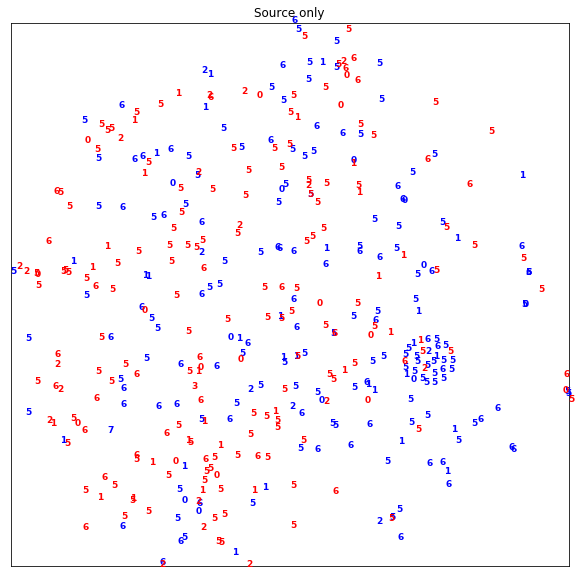

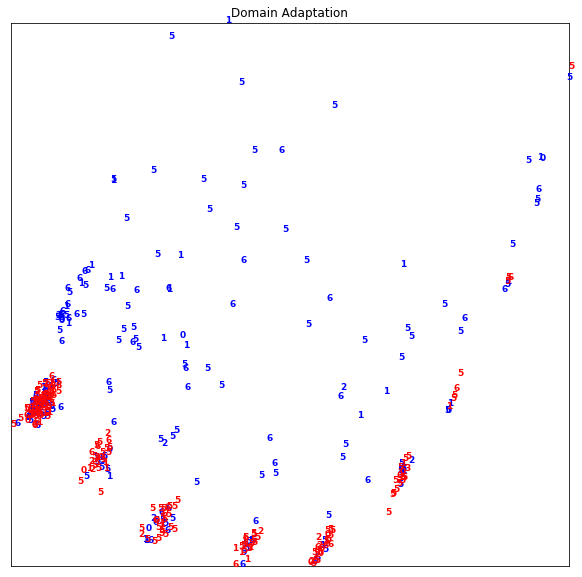

In [26]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
source_only_tsne = tsne.fit_transform(source_only_emb)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dann_tsne = tsne.fit_transform(dann_emb)
        
plot_embedding(source_only_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Source only')
plot_embedding(dann_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Domain Adaptation')

In [27]:
sess.close()